In [43]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
import pandas as pd
from tqdm import tqdm
import ndjson
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
#Loads model
model = SentenceTransformer('llmrails/ember-v1')

def similarity(a, b):
    embeddings = model.encode([a, b])
    similarity = cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

def load_data(model_metadata:dict):

    results_folder = "results/"
    df = pd.DataFrame()

    for model in model_metadata.keys():
        #loads ndjson data to a dict
        filename = model_metadata[model]['filename']
        with open("results/" + filename) as f:
            data = ndjson.load(f)

        df_single = pd.DataFrame(data)
        df_single['model_label'] = model
        df_single['model_size'] = model_metadata[model]['size_b']
        df_single['model_arch'] = model_metadata[model]['arch']

        df = pd.concat([df, df_single])

    return df

def df_merge_labels(df, label_1, label_2):

    suffix_1 = '_' + label_1
    suffix_2 = '_' + label_2

    df_label1 = df.loc[df['run_label'] == label_1].drop(columns=['model', 'system_prompt', 'temperature', 'model_variant'])
    df_label2 = df.loc[df['run_label'] == label_2].drop(columns=['model', 'system_prompt', 'temperature', 'model_variant'])
    merged_df = pd.merge(df_label1, df_label2, on=["question", "model_label", "model_size", "model_arch"], suffixes=(suffix_1, suffix_2))
    merged_df = merged_df.drop(columns=['run_label' + suffix_1, 'run_label' + suffix_2])
    return merged_df

def run_analysis_merge_abby_answers(df, label):

    # merges abby data with the real abby answers
    df_merge_abby = df[df['run_label'] == label]

    #loads abby answers
    with open("dear_abby_answers.ndjson") as f:
        data_abby_abby_answers  = ndjson.load(f)
    df_abby_answers = pd.DataFrame(data_abby_abby_answers)

    #merges abby answers with abby data
    df_merge_abby = pd.merge(df_merge_abby, df_abby_answers, on=["question"], suffixes=('_model', '_abby'))

    #calculates similarity
    df_merge_abby['similarity'] = df_merge_abby.apply(lambda row: similarity(row['answer_model'], row['answer_abby']), axis=1)

    return df_merge_abby

def run_analysis(df, label_1:str, label_2:str):

    df = load_data(model_metadata)
    df_merged = df_merge_labels(df, label_1, label_2)
    label_1 = 'answer' + '_' + label_1
    label_2 = 'answer' + '_' + label_2
    df_merged['similarity'] = df_merged.apply(lambda row: similarity(row[label_1], row[label_2]), axis=1)
    return df_merged

def plot_label(df, ax=None, variable = 'similarity', title=None, ylim=None, ylabel = "Cosine similarity", show_legend=False, show_xticks = True, variable_inverse = False):
    sns.set_theme(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))


    # cast model_size and negative_sentiment to float using loc
    df.loc[:, 'model_size'] = df['model_size'].astype(float)
    df.loc[:, variable] = df[variable].astype(float)

    df = df.sort_values(by=['model_size'])

    if variable_inverse:
        df[variable] = 1 - df[variable]

    sns.barplot(x="model_label", y=variable, hue="model_arch", data=df, ax=ax)

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)


    # add a 4x1 legend inside plot, ordering in this way: LLaMa2, GPT, Mistral, Other
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:4] + handles[0:1] + handles[4:], labels=labels[1:4] + labels[0:1] + labels[4:], loc='upper right', title="architecture")
    ax.get_legend().get_frame().set_alpha(1)


    if not show_xticks:
        ax.set_xticklabels([])

    if not show_legend:
        ax.get_legend().remove()

    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')

    if ylim is not None:
        ax.set_ylim(ylim)

    return ax

In [115]:
#Model metadata
model_metadata = {
    "GPT-3.5 Turbo": {
        "filename": "results_gpt_35.ndjson",
        "size_b": 175, #rumored
        "arch": "GPT",
    },
    "GPT-4": {
        "filename": "results_gpt_40.ndjson",
        "size_b": 1750, #rumored
        "arch": "GPT",
    },
    "GPT-4 Turbo": {
        "filename": "results_gpt_40_turbo.ndjson",
        "size_b": 583, #estimated from cost
        "arch": "GPT",
    },  
    "Llama2-7B": {
        "filename": "results_llama2_7b.ndjson",
        "size_b": 6.998, #for ordering purposes
        "arch": "Llama2",
    },
    "Llama2-7B*": {
        "filename": "results_llama2_7b_uncensored.ndjson",
        "size_b": 6.999, #for ordering purposes
        "arch": "Llama2",
    },
    "Llama2-70B": {
        "filename": "results_llama2-70b-chat.ndjson",
        "size_b": 70,
        "arch": "Llama2",
    },  
    "Llama2-70B*": {
        "filename": "results_llama2-70b-chat-uncensored.ndjson",
        "size_b": 70.0001, #for ordering purposes
        "arch": "Llama2",
    }, 
    "Mistral-7B": {
        "filename": "results_mistral-7b-instruct-v0.2.ndjson",
        "size_b": 7,
        "arch": "Mistral",
    },
    "Mixtral-8x7B": {
        "filename": "results_dolphin-2.5-mixtral-8x7b.ndjson",
        "size_b": 56,
        "arch": "Mistral",
    },
    "Zephyr-7B": {
        "filename": "results_zephyr-7b-beta.ndjson",
        "size_b": 7.001, #for ordering purposes
        "arch": "Mistral",
    },
    "PiVoT-0.1-Evil-a": {
        "filename": "results_pivot-0.1-evil-a.ndjson",
        "size_b": 7.002, #for ordering purposes
        "arch": "Mistral",
    },
    "Phi-2": {
        "filename": "results_phi2.ndjson",
        "size_b": 2.7,
        "arch": "Other",
    },
    "Zephyr-3B": {
        "filename": "results_stablelm-zephyr-3b.ndjson",
        "size_b": 3,
        "arch": "Other",
    },
    "Baichuan2-7B": {
        "filename": "results_baichuan2-7b.ndjson",
        "size_b": 7.003, #for ordering purposes
        "arch": "Other",
    },    
    "Yi-34B": {
        "filename": "results_yi-34b.ndjson",
        "size_b": 34,
        "arch": "Other",
    },
    "Tinyllama-1.1B": {
        "filename": "results_tinyllama_1b.ndjson",
        "size_b": 1,
        "arch": "Other",
    }       
}

In [116]:
#Runs analysis
df = load_data(model_metadata)
df_cynical = run_analysis(df, 'minimal', 'cynical')
df_realistic = run_analysis(df, 'minimal', 'realistic')
df_optimistic = run_analysis(df, 'minimal', 'optimistic')
df_abby = run_analysis(df, 'minimal', 'abby')
df_abby_answers = run_analysis_merge_abby_answers(df, 'abby')


C:\Users\Joao\AppData\Local\Temp\ipykernel_30920\3965414047.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_30920\3965414047.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_30920\3965414047.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_30920\3965414047.py:102: UserWarning: set_ticklabels() should only be used with a fixed numbe

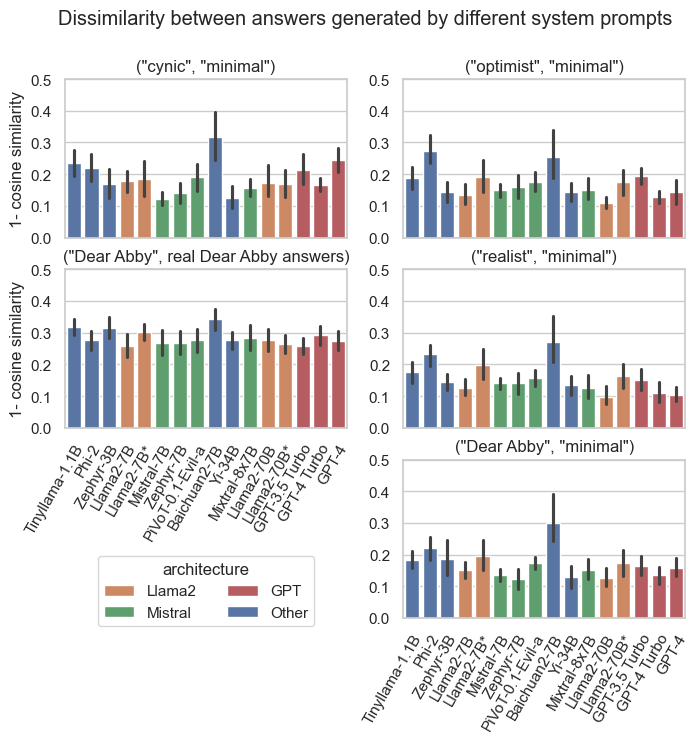

In [126]:
#Plots results
fig, axs = plt.subplots(3, 2, figsize=(8, 7))
ylim = (0,0.5)
ylabel = '1- cosine similarity'
fig.suptitle("Dissimilarity between answers generated by different system prompts")
plot_label(df_cynical, title = '("cynic", "minimal")', ylim = ylim, variable_inverse=True, ylabel=ylabel, ax=axs[0,0], show_legend=False, show_xticks=False)
plot_label(df_optimistic, title = '("optimist", "minimal")', ylim = ylim, variable_inverse=True, ylabel=None, ax=axs[0,1], show_legend=False, show_xticks=False)
plot_label(df_realistic, title = '("realist", "minimal")', ylim = ylim, variable_inverse=True, ylabel=None, ax=axs[1,1], show_legend=False, show_xticks=False)
plot_label(df_abby, title = '("Dear Abby", "minimal")', ylim = ylim, variable_inverse=True, ylabel=None, ax=axs[2,1], show_legend=False, show_xticks=True)
#"1 - cosine similarity"
plot_label(df_abby_answers, title = '("Dear Abby", real Dear Abby answers)', ylim = ylim, variable_inverse=True, ylabel=ylabel, ax=axs[1,0], show_legend=False, show_xticks=True)


#adds a custom legend in the bottom left corner
handles, labels = axs[0,0].get_legend_handles_labels()
axs[2,0].legend(handles=handles[1:4] + handles[0:1] + handles[4:], labels=labels[1:4] + labels[0:1] + labels[4:], loc='lower center', title="architecture", ncols=2, bbox_to_anchor=(0.5, -0.1))

#blanks axs[2,0]
axs[2,0].axis('off')

#saves figure
#fig.tight_layout()
fig.savefig('cosine_similarity.png', dpi=300, bbox_inches='tight')